In [1]:
#Блок в рамках которого импотряться математические подсчеты, падас и нампай
import pandas as pd
import numpy as np
from scipy.stats import iqr
from scipy import stats
from scipy.stats import skew
from scipy.stats import kurtosis
import scipy.stats
import scipy as sp
import scipy.stats as stats


import os
#Блок в рамках которого импотряться графики
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns 
from matplotlib.pyplot import figure
sns.set_style('darkgrid')


#Блок в рамках которого импотряться статистические пакеты
import statsmodels.api as sm 
import statsmodels.formula.api as smf 
from sklearn.preprocessing import OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS
from sklearn.decomposition import PCA
from statsmodels.stats.diagnostic import het_white, het_goldfeldquandt, het_breuschpagan
from statsmodels.stats.outliers_influence import reset_ramsey
from statsmodels.stats.diagnostic import compare_encompassing 

# Содержание работы

[Обработка и получение данных](#Introduction)
#### Выполнение заданий:
1. [Задание 1](#subparagraph1) -  Оценка линейной модели
2. [Задание 2](#subparagraph2) - Оценка полулогорифмической модели
3. [Задание 3](#subparagraph3) - Оценка линейной в логарифмах модели
4. [Задание 4](#subparagraph4) - Выбор модели (Тест Бокса-Кокса с преообразованием Зарембки)
5. [Задание 5](#subparagraph5) - Тестирование различия в ЗП (Тест Чоу)
6. [Задание 6](#subparagraph6) - Тестирование наличие выборосов (DFbettas, Leverage, Dffits)
7. [Задание 7](#subparagraph7) - Поиск мультиколлиниарности (VIF)
8. [Задание 8](#subparagraph8) - Применение PCA
9. [Задание 9](#subparagraph9) - Построение графика остатки-прогнозы
10. [Задание 10](#subparagraph10) - Тестирование гетероскедостичности (Тест Уйта, Голдфелда — Куандта, Бройша — Пагана
11. [Задание 11](#subparagraph11) - Проведение Теста Рамсея
12. [Задание 12](#subparagraph12) - Оценка и сравнение модели
13. [Задание 13](#subparagraph13) - Предложение функциональных форм
14. [Задание 14](#subparagraph14) - Итоговая оценка модели

### 0. Предварительный EDA

In [2]:
# cd "C:\Users\Alexandr\Documents\GitHub\smartphone-price-analysis\"

In [3]:
# making "directoryback"
os.chdir(os.path.normpath(os.getcwd() + os.sep + os.pardir))

In [4]:
data = pd.read_csv('Data/PhonesDF_years.csv')
data.sample(3)

,phone_title,price,rating,specs_score,likes,disp_diag,camera,storage,ram,battery_capacity,battery_type,disp_height,disp_width,oper_syst_type,oper_syst_vers,brand,year_of_release
350,Oppo A3,5099.0,3.8,65,45,6.20,8.0,128.0,4.0,3400.0,Li-Ion,2280.0,1080.0,Android,8,Oppo,2018
217,Xiaomi Redmi K20 Pro 8GB/256GB,91999.0,4.0,100,9,6.39,20.0,256.0,8.0,4000.0,Li-Po,2340.0,1080.0,Android,9,Xiaomi,2019
187,Nokia 8 Sirocco,1199.0,5.0,71,14,5.50,5.0,128.0,6.0,3260.0,Li-Ion,2560.0,1440.0,Android,8,Nokia,2018


In [5]:
# adding log price and PPI to dataset
data['log_price'] = np.log(data.price)
data['density'] = data.disp_height * data.disp_width / data.disp_diag**2

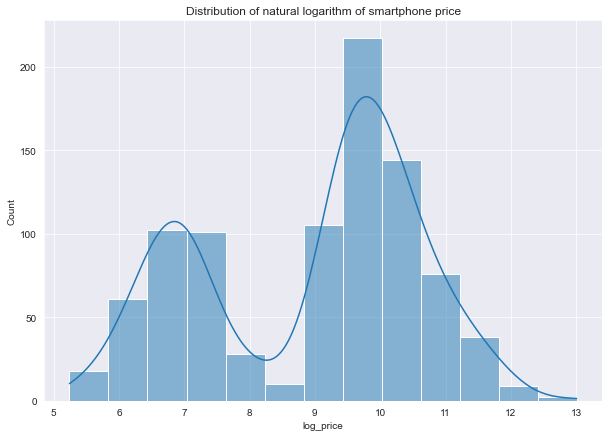

In [6]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.histplot(data=data, x='log_price', ax=ax,  kde=True)
ax.set_title('Distribution of natural logarithm of smartphone price');

Видно, что у нас получилось бимодальное распределение, где каждый колокол напомоминает нормальное распределение. Скорее всего, это связано с тем, что у нас в датасете есть много некорректно указанных цен (ошибка с порядком цены), так как в левой части распределения телефоны имеют цену ниже 2000 рублей, что выглядит неправдоподобно.

Избавимся от этих выбросов и построим новое распределение цены:

In [7]:
# correcting and saving data
data = data.loc[(data.price >= np.exp(8.3)) & (data.price < np.exp(12.5)), :].copy(deep=True)
data.to_csv('Data/PhonesDF_years_corrected.csv', index=False)

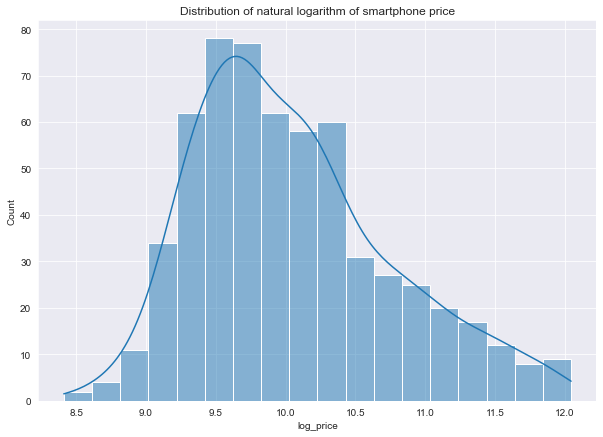

In [8]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.histplot(data=data, x='log_price', ax=ax,  kde=True)
ax.set_title('Distribution of natural logarithm of smartphone price');

Видно, что распределение логарифма цены имеет правостороннюю ассиметрию.

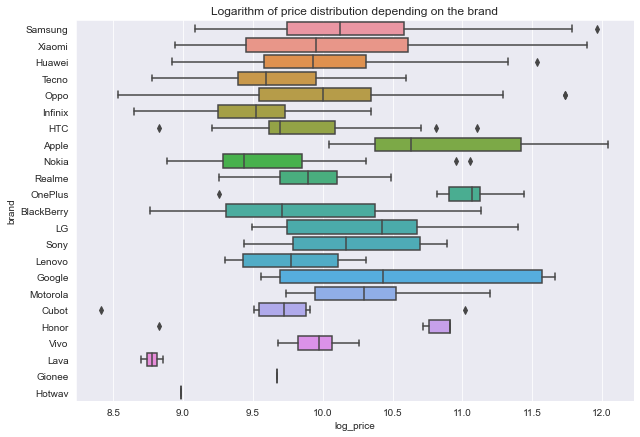

In [9]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.boxplot(data=data, y='brand', x='log_price', ax=ax, order=list(data.brand.value_counts().index))
ax.set_title('Logarithm of price distribution depending on the brand');

Видно, что айфоны и смартфоны бренда Google сущестсвенно дороже, чем остальные.

Построим, как цена и ее логарифм зависит от числовых характеристик смартфона.

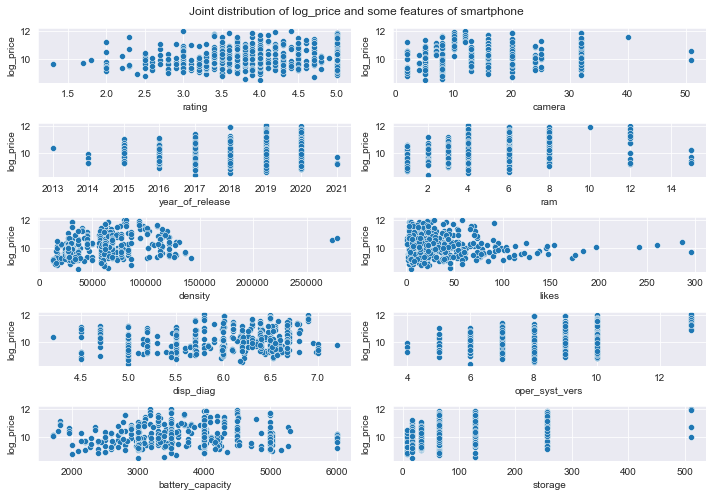

In [10]:
num_cols = list(set(list(data.select_dtypes([int, float]).columns)) - {'log_price', 'price', 'disp_width', 'disp_height', 'specs_score'})
fig, ax = plt.subplots(ncols=2, nrows=5, figsize=(10, 7))
for i, col in enumerate(num_cols):
    sns.scatterplot(data=data, x=col, y='log_price', ax=ax[i // 2][i % 2])
fig.suptitle('Joint distribution of log_price and some features of smartphone')
plt.tight_layout();

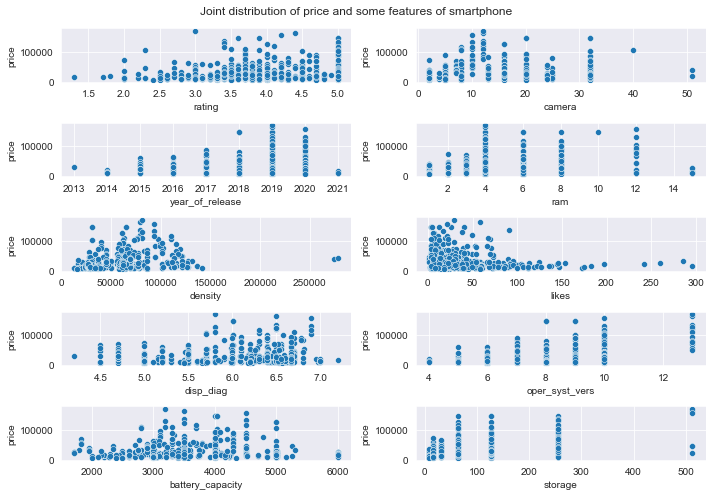

In [11]:
num_cols = list(set(list(data.select_dtypes([int, float]).columns)) - {'log_price', 'price', 'disp_width', 'disp_height', 'specs_score'})
fig, ax = plt.subplots(ncols=2, nrows=5, figsize=(10, 7))
for i, col in enumerate(num_cols):
    sns.scatterplot(data=data, x=col, y='price', ax=ax[i // 2][i % 2])
fig.suptitle('Joint distribution of price and some features of smartphone')
plt.tight_layout();

Таким образом, явной линейной и логлинейной звисимости тут не прослеживается. Попробуем отлогарифмировать признаки.

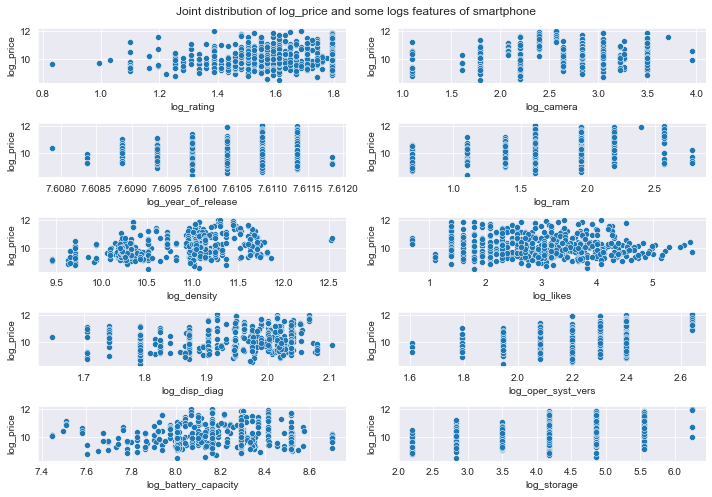

In [12]:
num_cols = list(set(list(data.select_dtypes([int, float]).columns)) - {'log_price', 'price', 'disp_width', 'disp_height', 'specs_score'})
fig, ax = plt.subplots(ncols=2, nrows=5, figsize=(10, 7))
for i, col in enumerate(num_cols):
    ax_cur = ax[i // 2][i % 2]
    sns.scatterplot(x=np.log1p(data[col]), y=data.log_price, ax=ax_cur)
    ax_cur.set_xlabel('log_' + col)
    ax_cur.set_ylabel('log_price')
fig.suptitle('Joint distribution of log_price and some logs features of smartphone')
plt.tight_layout();

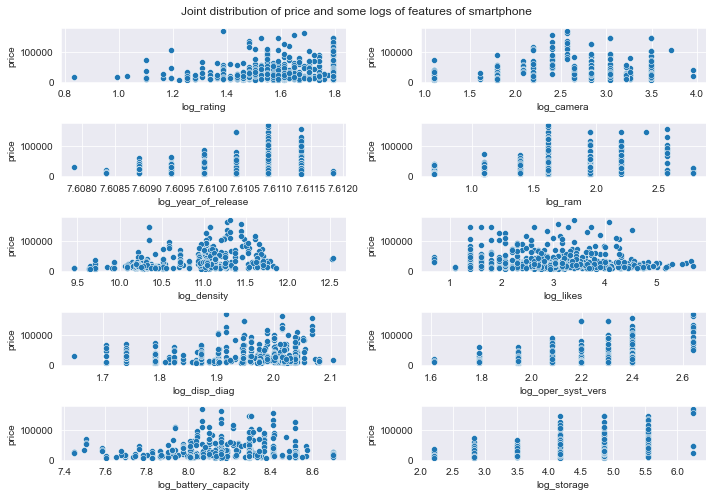

In [13]:
num_cols = list(set(list(data.select_dtypes([int, float]).columns)) - {'log_price', 'price', 'disp_width', 'disp_height', 'specs_score'})
fig, ax = plt.subplots(ncols=2, nrows=5, figsize=(10, 7))
for i, col in enumerate(num_cols):
    ax_cur = ax[i // 2][i % 2]
    sns.scatterplot(x=np.log1p(data[col]), y=data.price, ax=ax_cur)
    ax_cur.set_xlabel('log_' + col)
    ax_cur.set_ylabel('price')
fig.suptitle('Joint distribution of price and some logs of features of smartphone')
plt.tight_layout();

Явных зависимостей тоже не видно, но это всего лишь проекция данных на 2 оси, так что не стоит отчаиваться!

Посмотрим на корреляции 

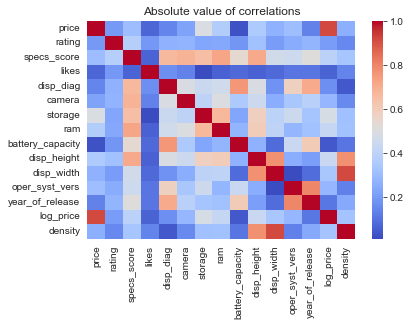

In [14]:
sns.heatmap(np.abs(data.corr()), cmap="coolwarm")
plt.title('Absolute value of correlations');

### 1. Обработка данных

In [15]:
data.sample(3)
data = data.drop(columns = ['price'])

In [16]:
def encode_and_bind(original_dataframe, feature_to_encode, drop=True, drop_cat=None):
    if drop_cat == None:
        dummies = pd.get_dummies(original_dataframe[[feature_to_encode]], drop_first = drop)
    else:
        dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
        dummies.drop(columns=feature_to_encode + '_' + drop_cat, inplace=True)
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop(columns = [feature_to_encode])
    return(res)

In [17]:
# # данные для вывода в отчете
# data = data.set_index('phone_title')
# data['Other_oper_syst'] = 0
# data['IOS_oper_syst'] = 0

# data.loc[data['oper_syst_type'] == 'Other', 'Other_oper_syst'] = 1 # Android - base dummy
# data.loc[data['oper_syst_type'] == 'IOS', 'IOS_oper_syst'] = 1 
# data = data.drop(columns = ['oper_syst_type', 'likes'])

# data = encode_and_bind(data, 'battery_type', drop=False)
# data = encode_and_bind(data, 'brand', drop=False)
# data = data.rename(columns = {'battery_type_ Li-Po':'battery_type_LiPo', 'battery_type_ Li-Ion':'battery_type_LiIon'})

# data.to_csv('Data/PhonesDFUndropped.csv', index=False)

In [18]:
data = data.set_index('phone_title')

In [19]:
data['Other_oper_syst'] = 0
data['IOS_oper_syst'] = 0

data.loc[data['oper_syst_type'] == 'Other', 'Other_oper_syst'] = 1 # Android - base dummy
data.loc[data['oper_syst_type'] == 'IOS', 'IOS_oper_syst'] = 1 
data = data.drop(columns = ['oper_syst_type', 'likes'])

In [20]:
data = encode_and_bind(data, 'battery_type')
data = encode_and_bind(data, 'brand', drop_cat='Xiaomi')

In [21]:
data = data.rename(columns = {'battery_type_ Li-Po':'battery_type_LiPo'})

In [22]:
data.sample(3)

,rating,specs_score,disp_diag,camera,storage,ram,battery_capacity,disp_height,disp_width,oper_syst_vers,...,brand_Lenovo,brand_Motorola,brand_Nokia,brand_OnePlus,brand_Oppo,brand_Realme,brand_Samsung,brand_Sony,brand_Tecno,brand_Vivo
phone_title,,,,,,,,,,,,,,,,,,,,,
Hotwav Cosmos V23,3.5,49,4.7,8.0,32.0,3.0,3000.0,1280.0,720.0,6,...,0,0,0,0,0,0,0,0,0,0
Apple iPhone SE (2020) 128GB,3.6,56,4.7,7.0,128.0,3.0,1821.0,1334.0,750.0,13,...,0,0,0,0,0,0,0,0,0,0
Huawei P20 Lite (2019) 4GB/64GB,4.2,65,6.4,16.0,64.0,4.0,4000.0,2310.0,1080.0,9,...,0,0,0,0,0,0,0,0,0,0


In [23]:
from scipy.stats import t
X_columns = data.drop(columns=['log_price', 'IOS_oper_syst', 'oper_syst_vers', 'disp_height', 'disp_width', 'specs_score']).columns

ols = smf.ols(f"log_price ~ {' + '.join(map(str, X_columns))}", data=data).fit()

n = data.shape[0]
k = X_columns.shape[0] + 1
t_crit_r = t.ppf(0.975, n - k - 1)
t_crit_l = -t_crit_r
resid_std = ols.outlier_test()['student_resid']
mask = (resid_std < t_crit_r) & (resid_std > t_crit_l)

data = data[mask]

In [24]:
data['brand_Hotwav'].unique()

array([0, 1], dtype=uint8)

In [25]:
data = data.drop(columns = ['brand_Hotwav'])

### 2. EDA

In [26]:
np.round(data.describe(), 2)

,rating,specs_score,disp_diag,camera,storage,ram,battery_capacity,disp_height,disp_width,oper_syst_vers,...,brand_Lenovo,brand_Motorola,brand_Nokia,brand_OnePlus,brand_Oppo,brand_Realme,brand_Samsung,brand_Sony,brand_Tecno,brand_Vivo
count,560.00,560.00,560.00,560.00,560.00,560.00,560.00,560.00,560.00,560.00,...,560.00,560.00,560.00,560.00,560.00,560.00,560.00,560.00,560.00,560.00
mean,3.84,66.64,6.00,13.04,83.09,4.46,3755.34,1967.91,986.27,8.43,...,0.02,0.01,0.04,0.03,0.05,0.03,0.18,0.02,0.08,0.01
std,0.75,21.26,0.59,8.65,77.00,2.56,864.34,555.80,277.84,1.62,...,0.14,0.10,0.19,0.17,0.23,0.18,0.38,0.14,0.27,0.09
min,1.30,28.00,4.20,2.00,8.00,1.00,1715.00,480.00,480.00,4.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,3.30,50.00,5.50,7.00,32.00,3.00,3020.00,1520.00,720.00,7.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,3.80,62.00,6.20,9.00,64.00,4.00,4000.00,1920.00,1080.00,9.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,4.40,88.00,6.50,16.00,128.00,6.00,4200.00,2340.00,1080.00,10.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,5.00,100.00,7.20,51.00,512.00,15.00,6000.00,3840.00,3840.00,13.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [27]:
def mean_mode_median(dataframe: pd.DataFrame) -> pd.DataFrame:
    '''
    Function for finding mean median and mode of continious data
    '''
    df = pd.DataFrame()
    df['Mode'] = stats.mode(dataframe)[0][0]
    df['Median'] = np.median(dataframe, axis=0)
    df['Mean'] = np.mean(dataframe, axis=0).to_numpy()
    
    df = np.round(df, 2)
    
    df.index = dataframe.columns
    return df

In [28]:
mean_mode_median(data)

,Mode,Median,Mean
rating,5.00,3.80,3.84
specs_score,100.00,62.00,66.64
disp_diag,5.50,6.20,6.00
camera,8.00,9.00,13.04
storage,128.00,64.00,83.09
ram,4.00,4.00,4.46
battery_capacity,4000.00,4000.00,3755.34
disp_height,2340.00,1920.00,1967.91
disp_width,1080.00,1080.00,986.27
oper_syst_vers,9.00,9.00,8.43


### 3. Multicollinearity

In [29]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

data_m = add_constant(data)
data_m = data_m.drop(columns = ['log_price'])
pd.Series([variance_inflation_factor(data_m.values, i) 
               for i in range(data_m.shape[1])], 
              index=data_m.columns)


c:\Users\Anton\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
c:\Users\Anton\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


const                2.205982e+07
rating               1.321102e+00
specs_score          7.252871e+00
disp_diag            9.543227e+00
camera               2.161979e+00
storage              2.722887e+00
ram                  2.753160e+00
battery_capacity     3.650272e+00
disp_height          1.761298e+01
disp_width           1.273427e+01
oper_syst_vers       1.667229e+01
year_of_release      1.284238e+01
density              3.015877e+01
Other_oper_syst      2.123084e+00
IOS_oper_syst                 inf
battery_type_LiPo    2.046950e+00
brand_Apple                   inf
brand_BlackBerry     1.587227e+00
brand_Cubot          1.115768e+00
brand_Gionee         1.046405e+00
brand_Google         1.389320e+00
brand_HTC            1.541318e+00
brand_Honor          1.082492e+00
brand_Huawei         1.847533e+00
brand_Infinix        1.589591e+00
brand_LG             1.299322e+00
brand_Lava           1.101235e+00
brand_Lenovo         1.212776e+00
brand_Motorola       1.146246e+00
brand_Nokia   

In [30]:
data_m = data_m.drop(columns = 'IOS_oper_syst')
data = data.drop(columns = 'IOS_oper_syst')

In [31]:
pd.Series([variance_inflation_factor(data_m.values, i) 
               for i in range(data_m.shape[1])], 
              index=data_m.columns)


const                2.205982e+07
rating               1.321102e+00
specs_score          7.252871e+00
disp_diag            9.543227e+00
camera               2.161979e+00
storage              2.722887e+00
ram                  2.753160e+00
battery_capacity     3.650272e+00
disp_height          1.761298e+01
disp_width           1.273427e+01
oper_syst_vers       1.667229e+01
year_of_release      1.284238e+01
density              3.015877e+01
Other_oper_syst      2.123084e+00
battery_type_LiPo    2.046950e+00
brand_Apple          6.652641e+00
brand_BlackBerry     1.587227e+00
brand_Cubot          1.115768e+00
brand_Gionee         1.046405e+00
brand_Google         1.389320e+00
brand_HTC            1.541318e+00
brand_Honor          1.082492e+00
brand_Huawei         1.847533e+00
brand_Infinix        1.589591e+00
brand_LG             1.299322e+00
brand_Lava           1.101235e+00
brand_Lenovo         1.212776e+00
brand_Motorola       1.146246e+00
brand_Nokia          1.470225e+00
brand_OnePlus 

In [32]:
data_m = data_m.drop(columns = ['disp_height', 'disp_width', 'specs_score'])
data_m['density'] = data['density']

data = data.drop(columns = ['disp_height', 'disp_width', 'specs_score'])

In [33]:
np.round(pd.Series([variance_inflation_factor(data_m.values, i) 
               for i in range(data_m.shape[1])], 
              index=data_m.columns), 2)


const                21947371.26
rating                      1.29
disp_diag                   4.91
camera                      1.72
storage                     2.42
ram                         2.44
battery_capacity            3.38
oper_syst_vers             16.43
year_of_release            12.77
density                     1.85
Other_oper_syst             2.10
battery_type_LiPo           1.94
brand_Apple                 6.36
brand_BlackBerry            1.56
brand_Cubot                 1.11
brand_Gionee                1.04
brand_Google                1.35
brand_HTC                   1.46
brand_Honor                 1.08
brand_Huawei                1.77
brand_Infinix               1.42
brand_LG                    1.26
brand_Lava                  1.09
brand_Lenovo                1.19
brand_Motorola              1.13
brand_Nokia                 1.42
brand_OnePlus               1.30
brand_Oppo                  1.33
brand_Realme                1.24
brand_Samsung               1.89
brand_Sony

In [34]:
data_new = data_m.copy()
data_new.drop(columns='oper_syst_vers', inplace=True)
data.drop(columns='oper_syst_vers', inplace=True)

In [35]:
np.round(pd.Series([variance_inflation_factor(data_new.values, i) 
               for i in range(data_new.shape[1])], 
              index=data_new.columns), 2)


const                4869981.38
rating                     1.29
disp_diag                  4.59
camera                     1.70
storage                    2.41
ram                        2.44
battery_capacity           3.38
year_of_release            2.84
density                    1.85
Other_oper_syst            1.24
battery_type_LiPo          1.92
brand_Apple                1.74
brand_BlackBerry           1.54
brand_Cubot                1.09
brand_Gionee               1.04
brand_Google               1.22
brand_HTC                  1.46
brand_Honor                1.07
brand_Huawei               1.75
brand_Infinix              1.42
brand_LG                   1.26
brand_Lava                 1.09
brand_Lenovo               1.18
brand_Motorola             1.13
brand_Nokia                1.41
brand_OnePlus              1.29
brand_Oppo                 1.33
brand_Realme               1.24
brand_Samsung              1.89
brand_Sony                 1.33
brand_Tecno                1.63
brand_Vi

### 3. Heteroskedasticity

In [36]:
# X_columns = data.drop(columns = ['log_price', 'oper_syst_vers']).columns
X_columns = data_new.columns[1:]
print(' + '.join(map(str, X_columns)))


rating + disp_diag + camera + storage + ram + battery_capacity + year_of_release + density + Other_oper_syst + battery_type_LiPo + brand_Apple + brand_BlackBerry + brand_Cubot + brand_Gionee + brand_Google + brand_HTC + brand_Honor + brand_Huawei + brand_Infinix + brand_LG + brand_Lava + brand_Lenovo + brand_Motorola + brand_Nokia + brand_OnePlus + brand_Oppo + brand_Realme + brand_Samsung + brand_Sony + brand_Tecno + brand_Vivo


In [37]:
ols = smf.ols(f"log_price ~ {' + '.join(map(str, X_columns))}", data=data).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     23.15
Date:                Tue, 09 May 2023   Prob (F-statistic):           8.05e-79
Time:                        12:17:41   Log-Likelihood:                -311.10
No. Observations:                 560   AIC:                             686.2
Df Residuals:                     528   BIC:                             824.7
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -59.6402     40.502     -1.473      0.141    -139.204      19.924
rating                0.0645      0.028      2.326      0.020       0.010       0.119
disp_diag             0.0245      0.067      0.366      0.714      -0.107       0.156
camera                0.0076      0.003      2.731      0.007       0.002       0.013
storage               0.0020      0.000      5.504      0.000       0.001       0.003
ram                   0.0564      0.011      5.033      0.000       0.034       0.078
battery_capacity  -5.627e-05   3.91e-05     -1.440      0.151      -0.000    2.05e-05
year_of_release       0.0340      0.020      1.689      0.092      -0.006       0.074
density            2.532e-06   8.32e-07      3.043      0.002    8.98e-07    4.17e-06
Other_oper_syst       0.2206      0.342      0.645      0.519      -0.452       0.893
battery_type_LiPo     0.0364      0.051      0.714      0.475      -0.064       0.137
brand_Apple           0.9865      0.115      8.585      0.000       0.761       1.212
brand_BlackBerry      0.1967      0.158      1.248      0.212      -0.113       0.506
brand_Cubot           0.3283      0.227      1.443      0.149      -0.118       0.775
brand_Gionee         -0.1345      0.314     -0.429      0.668      -0.751       0.482
brand_Google          0.5849      0.146      4.004      0.000       0.298       0.872
brand_HTC             0.0116      0.097      0.119      0.905      -0.179       0.202
brand_Honor           0.7391      0.202      3.654      0.000       0.342       1.136
brand_Huawei         -0.0303      0.074     -0.410      0.682      -0.175       0.115
brand_Infinix        -0.1448      0.090     -1.603      0.109      -0.322       0.033
brand_LG              0.4596      0.137      3.360      0.001       0.191       0.728
brand_Lava           -0.6214      0.321     -1.937      0.053      -1.252       0.009
brand_Lenovo         -0.0170      0.144     -0.118      0.906      -0.300       0.266
brand_Motorola        0.6604      0.189      3.491      0.001       0.289       1.032
brand_Nokia          -0.1023      0.112     -0.912      0.362      -0.323       0.118
brand_OnePlus         0.6255      0.125      5.001      0.000       0.380       0.871
brand_Oppo           -0.0279      0.094     -0.297      0.767      -0.213       0.157
brand_Realme         -0.0413      0.116     -0.356      0.722      -0.269       0.186
brand_Samsung         0.1881      0.066      2.868      0.004       0.059       0.317
brand_Sony            0.3808      0.146      2.608      0.009       0.094       0.668
brand_Tecno           0.0478      0.088      0.543      0.587      -0.125       0.221
brand_Vivo            0.1503      0.203      0.741      0.459      -0.248       0.549
=========================================================================

In [38]:
hat_log_price = ols.fittedvalues


c:\Users\Anton\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


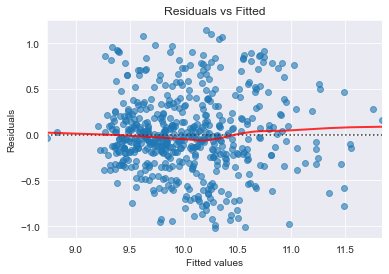

In [39]:
fig_1 = plt.figure(1)
fig_1.axes[0] = sns.residplot(hat_log_price, data['log_price'],
                                  lowess=True,
                                  scatter_kws={'alpha': 0.6},
                                  line_kws={'color': 'red', 'lw': 2, 'alpha': 0.8})
fig_1.axes[0].set_title('Residuals vs Fitted')
fig_1.axes[0].set_xlabel('Fitted values')
fig_1.axes[0].set_ylabel('Residuals')
plt.show()

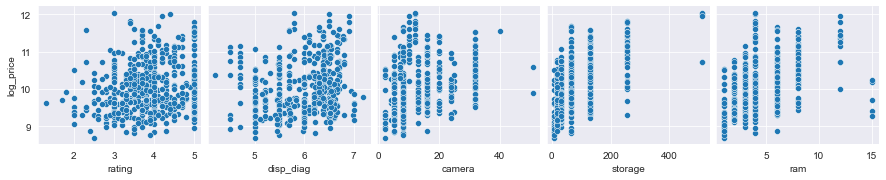

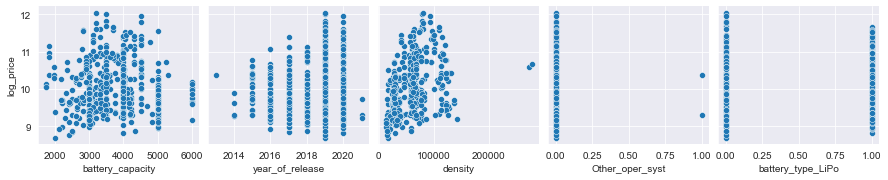

In [40]:
sns.pairplot(data, x_vars=X_columns[0:5], y_vars=["log_price"])
sns.pairplot(data, x_vars=X_columns[5:10], y_vars=["log_price"])
# sns.pairplot(data, x_vars=X_columns[10:15], y_vars=["log_price"]) # Неинтерпретируемые графики
# sns.pairplot(data, x_vars=X_columns[15:20], y_vars=["log_price"]) # Неинтерпретируемые графики
plt.show()

#### 3.1 Тест на проверку гетероскедостичности

$$\begin{align}
&H0: \sigma_{i}^2  = \sigma^2, \forall \ i \in \ \{0,1,2,3,4,5\} \ (гомоскедостичность) \\
&H1: \exists \ i, j : \sigma_{i}^2  \neq \sigma_{k}^2 \ (гетероскедостичность)
\end{align}$$

#### 3.1.1 Тест Уйата

In [41]:
X = data.loc[:, X_columns].copy()
y = data['log_price']
model = sm.OLS(y, X).fit()


In [42]:
white_test = het_white(model.resid,  model.model.exog)


In [43]:
labels = ['Chi^2 observed statistic', 'Chi^2 obserrved statistic p-value', 'F-Statistic', 'F-Test p-value']
res_white = dict(zip(labels, white_test))
print(f"Chi^2 observed statistic: {res_white['Chi^2 observed statistic']}")
# print(f"Chi^2 critical Statistics = {sp.stats.chi2.isf(1-0.1, np.shape(model.model.exog)[1] - 1, loc=0)}") Проверить док
print(f"P-value = {res_white['Chi^2 obserrved statistic p-value']}")

Chi^2 observed statistic: 300.7072009056208
P-value = 2.7108162771280917e-06


Нулевая гипотеза о гомоскедостичности остатков отвергается на любом разумном уровне значимости

#### 3.1.2 Бройша-Пагана

In [44]:
bp_test = het_breuschpagan(model.resid,  model.model.exog)
labels = ['Chi^2 observed statistic', 'Chi^2 obserrved statistic p-value', 'F-Statistic', 'F-Test p-value']
res_bp = dict(zip(labels, bp_test))
print(f"Chi^2 observed statistic: {res_bp['Chi^2 observed statistic']}")
# print(f"Chi^2 critical Statistics = {sp.stats.chi2.isf(1-0.1, np.shape(model.model.exog)[1] - 1, loc=0)}")  Проверить док
print(f"P-value = {res_bp['Chi^2 obserrved statistic p-value']}")


Chi^2 observed statistic: 266.03377593609486
P-value = 1.1848494057482607e-39


#### 3.1.3 Тест Голдфелда — Куандта

In [45]:
goldfeldquandt = het_goldfeldquandt(model.resid,  model.model.exog)
labels = ['F-statistics observed', 'F-statistics p-value', 'ordering']
res_goldfeldquandt = dict(zip(labels, goldfeldquandt))
print(f"F observed statistic: {res_goldfeldquandt['F-statistics observed']}")
print(f"P-value = {res_goldfeldquandt['F-statistics p-value']}")



F observed statistic: 1.1796218088248691
P-value = 0.09368978725442242


### 3.2 Решение проблемы гетероскедостичности

Для решение этой проблемы воспользуюсь робастными оценками в форме Уайта

##### 3.2.1 Общая информации модели до применение робастных оценок

In [46]:
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     23.15
Date:                Tue, 09 May 2023   Prob (F-statistic):           8.05e-79
Time:                        12:17:44   Log-Likelihood:                -311.10
No. Observations:                 560   AIC:                             686.2
Df Residuals:                     528   BIC:                             824.7
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -59.6402     40.502     -1.473      0.141    -139.204      19.924
rating                0.0645      0.028      2.326      0.020       0.010       0.119
disp_diag             0.0245      0.067      0.366      0.714      -0.107       0.156
camera                0.0076      0.003      2.731      0.007       0.002       0.013
storage               0.0020      0.000      5.504      0.000       0.001       0.003
ram                   0.0564      0.011      5.033      0.000       0.034       0.078
battery_capacity  -5.627e-05   3.91e-05     -1.440      0.151      -0.000    2.05e-05
year_of_release       0.0340      0.020      1.689      0.092      -0.006       0.074
density            2.532e-06   8.32e-07      3.043      0.002    8.98e-07    4.17e-06
Other_oper_syst       0.2206      0.342      0.645      0.519      -0.452       0.893
battery_type_LiPo     0.0364      0.051      0.714      0.475      -0.064       0.137
brand_Apple           0.9865      0.115      8.585      0.000       0.761       1.212
brand_BlackBerry      0.1967      0.158      1.248      0.212      -0.113       0.506
brand_Cubot           0.3283      0.227      1.443      0.149      -0.118       0.775
brand_Gionee         -0.1345      0.314     -0.429      0.668      -0.751       0.482
brand_Google          0.5849      0.146      4.004      0.000       0.298       0.872
brand_HTC             0.0116      0.097      0.119      0.905      -0.179       0.202
brand_Honor           0.7391      0.202      3.654      0.000       0.342       1.136
brand_Huawei         -0.0303      0.074     -0.410      0.682      -0.175       0.115
brand_Infinix        -0.1448      0.090     -1.603      0.109      -0.322       0.033
brand_LG              0.4596      0.137      3.360      0.001       0.191       0.728
brand_Lava           -0.6214      0.321     -1.937      0.053      -1.252       0.009
brand_Lenovo         -0.0170      0.144     -0.118      0.906      -0.300       0.266
brand_Motorola        0.6604      0.189      3.491      0.001       0.289       1.032
brand_Nokia          -0.1023      0.112     -0.912      0.362      -0.323       0.118
brand_OnePlus         0.6255      0.125      5.001      0.000       0.380       0.871
brand_Oppo           -0.0279      0.094     -0.297      0.767      -0.213       0.157
brand_Realme         -0.0413      0.116     -0.356      0.722      -0.269       0.186
brand_Samsung         0.1881      0.066      2.868      0.004       0.059       0.317
brand_Sony            0.3808      0.146      2.608      0.009       0.094       0.668
brand_Tecno           0.0478      0.088      0.543      0.587      -0.125       0.221
brand_Vivo            0.1503      0.203      0.741      0.459      -0.248       0.549
=========================================================================

##### 3.2.2 Применение робастных оценок

In [47]:
ols_robust = ols.get_robustcov_results()
ols_robust.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     99.35
Date:                Tue, 09 May 2023   Prob (F-statistic):          2.72e-198
Time:                        12:17:44   Log-Likelihood:                -311.10
No. Observations:                 560   AIC:                             686.2
Df Residuals:                     528   BIC:                             824.7
Df Model:                          31                                         
Covariance Type:                  HC1                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -59.6402     40.413     -1.476      0.141    -139.031      19.751
rating                0.0645      0.029      2.259      0.024       0.008       0.121
disp_diag             0.0245      0.069      0.356      0.722      -0.111       0.160
camera                0.0076      0.003      2.594      0.010       0.002       0.013
storage               0.0020      0.000      4.462      0.000       0.001       0.003
ram                   0.0564      0.014      4.106      0.000       0.029       0.083
battery_capacity  -5.627e-05   4.04e-05     -1.394      0.164      -0.000     2.3e-05
year_of_release       0.0340      0.020      1.695      0.091      -0.005       0.073
density            2.532e-06   8.23e-07      3.076      0.002    9.15e-07    4.15e-06
Other_oper_syst       0.2206      0.451      0.489      0.625      -0.666       1.107
battery_type_LiPo     0.0364      0.053      0.681      0.496      -0.069       0.141
brand_Apple           0.9865      0.121      8.142      0.000       0.748       1.225
brand_BlackBerry      0.1967      0.218      0.903      0.367      -0.231       0.625
brand_Cubot           0.3283      0.092      3.573      0.000       0.148       0.509
brand_Gionee         -0.1345      0.113     -1.189      0.235      -0.357       0.088
brand_Google          0.5849      0.259      2.257      0.024       0.076       1.094
brand_HTC             0.0116      0.104      0.111      0.912      -0.193       0.216
brand_Honor           0.7391      0.172      4.309      0.000       0.402       1.076
brand_Huawei         -0.0303      0.082     -0.371      0.711      -0.191       0.130
brand_Infinix        -0.1448      0.077     -1.874      0.062      -0.297       0.007
brand_LG              0.4596      0.154      2.988      0.003       0.157       0.762
brand_Lava           -0.6214      0.096     -6.499      0.000      -0.809      -0.434
brand_Lenovo         -0.0170      0.088     -0.194      0.846      -0.189       0.155
brand_Motorola        0.6604      0.195      3.395      0.001       0.278       1.042
brand_Nokia          -0.1023      0.087     -1.170      0.243      -0.274       0.069
brand_OnePlus         0.6255      0.100      6.240      0.000       0.429       0.822
brand_Oppo           -0.0279      0.095     -0.293      0.770      -0.215       0.159
brand_Realme         -0.0413      0.107     -0.386      0.700      -0.252       0.169
brand_Samsung         0.1881      0.072      2.626      0.009       0.047       0.329
brand_Sony            0.3808      0.154      2.471      0.014       0.078       0.684
brand_Tecno           0.0478      0.088      0.541      0.589      -0.126       0.221
brand_Vivo            0.1503      0.067      2.246      0.025       0.019       0.282
=========================================================================

### 4. Спецификация модели

In [48]:
rams = reset_ramsey(ols_robust, degree = 2)
print(f"{rams.summary().split(', ')[0][-19:]}")
print(f"{rams.summary().split(', ')[1]}")

ray([[2.69822387]])
p=0.10105660465744139


In [49]:
rams = reset_ramsey(ols_robust, degree = 3)
print(f"{rams.summary().split(', ')[0][-19:]}")
print(f"{rams.summary().split(', ')[1]}")

ray([[3.47203817]])
p=0.031767244702886596


In [50]:
rams = reset_ramsey(ols_robust, degree = 4)
print(f"{rams.summary().split(', ')[0][-20:]}")
print(f"{rams.summary().split(', ')[1]}")

rray([[2.44064722]])
p=0.0635380107792902


Нулевая гипотеза не отвергается на уровне значимости 1% для любых степеней, следовательно гипотеза о том, что модель правильно специфицирована не отвергается.

### 5. Функциональная форма

#### 1. PE-тест

In [51]:
Lin_data = data.copy()
Lin_data['price'] = np.exp(Lin_data['log_price'])
Lin_data = Lin_data.drop(columns = ['log_price'])

Log_data = data.copy()

In [52]:
Lin_data.columns

Index(['rating', 'disp_diag', 'camera', 'storage', 'ram', 'battery_capacity',
       'year_of_release', 'density', 'Other_oper_syst', 'battery_type_LiPo',
       'brand_Apple', 'brand_BlackBerry', 'brand_Cubot', 'brand_Gionee',
       'brand_Google', 'brand_HTC', 'brand_Honor', 'brand_Huawei',
       'brand_Infinix', 'brand_LG', 'brand_Lava', 'brand_Lenovo',
       'brand_Motorola', 'brand_Nokia', 'brand_OnePlus', 'brand_Oppo',
       'brand_Realme', 'brand_Samsung', 'brand_Sony', 'brand_Tecno',
       'brand_Vivo', 'price'],
      dtype='object')

In [53]:
lin_model = sm.OLS(Lin_data['price'], Lin_data.drop(columns = ['price'])).fit()
y_lin_hat = lin_model.predict(Lin_data.drop(columns = ['price']))

In [54]:
log_model = sm.OLS(Log_data['log_price'], Log_data.drop(columns = ['log_price'])).fit()
y_log_hat = log_model.predict(Log_data.drop(columns = ['log_price']))

In [55]:
Lin_data['log_part'] = y_log_hat - np.log(y_lin_hat)
Log_data['lin_part'] = y_lin_hat - np.exp(y_log_hat)

In [56]:
lin_logpart_model = sm.OLS(Lin_data['price'], Lin_data.drop(columns = ['price'])).fit()
lin_logpart_model = lin_logpart_model.get_robustcov_results()

log_linpart_model = sm.OLS(Log_data['log_price'], Log_data.drop(columns = ['log_price'])).fit()
log_linpart_model = log_linpart_model.get_robustcov_results()


In [57]:
# print(f"P-value log_part in lin_logpart_model = {lin_logpart_model.pvalues['log_part']}") # sigma_lin
# print(f"P-value lin_part in log_linpart_model = {log_linpart_model.pvalues['lin_part']}") # sigma_log

In [58]:
print(f"P-value log_part in lin_logpart_model = {lin_logpart_model.pvalues[-1]}") # sigma_lin
print(f"P-value lin_part in log_linpart_model = {log_linpart_model.pvalues[-1]}") # sigma_log

P-value log_part in lin_logpart_model = 1.622795680160838e-07
P-value lin_part in log_linpart_model = 0.5245613330373913


На любом разумном уровне значимости нулевая гипотеза о незначимости логорифмической части в линейной модели отвергается, то есть sigma_lin значим. В то же время значимость линейней части в полулогорифмической модели отвергается при любом разумном уровне значимости, то есть не отвергается гипотеза, что sigma_log = 0. Другими словами, линейная часть в полулогорифмической модели не позволило лучше объяснить данные, в то время как логорифмическая чать в линейной модели значительно показало значимый результат.

Следовательно относительно PE-теста необходимо выбрать полулогорифмическую модель.

#### 5.1 Проверка нормальности остатков (Тест Харке-Бера)

In [59]:
_, p_value = stats.jarque_bera(ols_robust.resid)
print(f"Тест Харке-Бера p_value = {p_value}") #

Тест Харке-Бера p_value = 0.06423799402861008


На 10% уровне значимости нулевая гипотеза, что остатки имеют нормальное распределение, не отвергается. Следовательно, так как остатки являются оценкой ошибок, то не отвергается, что выполняется предпосылка КЛММР о нормальной распределенности ошибок.

In [60]:
# data.to_csv('Data/PhonesDF_years_corrected_v2.csv', index=False)